In [1]:
import pandas as pd
from scipy.stats import zscore
from tabulate import tabulate
from unidecode import unidecode
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')
pd.set_option('mode.use_inf_as_na', True)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
empresas = pd.read_csv("cad_cia_aberta.csv",sep=';',encoding='latin-1')
empresas['DENOM_COMERC'].fillna(empresas['DENOM_SOCIAL'], inplace=True)

In [3]:
empresas.pivot_table(index='SIT_EMISSOR',columns='SIT',values='DENOM_COMERC',aggfunc='count').reset_index()

SIT,SIT_EMISSOR,ATIVO,CANCELADA,SUSPENSO(A) - DECISÃO ADM
0,EM LIQUIDAÇÃO JUDICIAL,1.00,2.00,NaN
1,EM RECUPERAÇÃO EXTRAJUDICIAL,1.00,1.00,NaN
2,EM RECUPERAÇÃO JUDICIAL OU EQUIVALENTE,20.00,10.00,NaN
3,FALIDA,4.00,15.00,1.00
4,FASE OPERACIONAL,713.00,321.00,1.00
5,FASE PRÉ-OPERACIONAL,36.00,114.00,NaN
6,LIQUIDAÇÃO EXTRAJUDICIAL,6.00,8.00,1.00
7,PARALISADA,3.00,3.00,NaN


In [4]:
# Remova 'Emp. Adm. Part. - ' de todas as entradas na coluna 'SETOR_ATIV'
empresas['SETOR_ATIV'] = empresas['SETOR_ATIV'].str.replace('Emp. Adm. Part. - ', '')

empresas_ativas = empresas[(empresas['SIT'] == "ATIVO") & (empresas['SIT_EMISSOR'].isin(['FASE OPERACIONAL','EM RECUPERAÇÃO JUDICIAL OU EQUIVALENTE']))]

cod_empresas_filtro = empresas_ativas['CD_CVM'].unique()
len(cod_empresas_filtro)

650

In [5]:
relatorios = {'peça':[],'dados':[]}
anos = ['2018','2020','2022']

tipo_peca = 'dfp'
pecas = [
    "_cia_aberta_DRE_con_",
    "_cia_aberta_BPA_con_",
    "_cia_aberta_BPP_con_",
    "_cia_aberta_DFC_MI_con_"]

pecas_adicionais = []


#loop para carregar as peças

for peca in pecas:
    df_peça_list = []
    for ano in anos:
        df_peça_ano = pd.read_csv(tipo_peca+"_cia_aberta_"+ano+"\\"+tipo_peca+peca+ano+".CSV",sep=';',encoding='latin-1')
        df_peça_ano = df_peça_ano[df_peça_ano['CD_CVM'].isin(cod_empresas_filtro)]
        df_peça_ano['DS_CONTA'] = df_peça_ano['DS_CONTA'].apply(lambda x: unidecode(x).lower())
        df_peça_list.append(df_peça_ano)
        
    df_peça = pd.concat(df_peça_list)
    relatorios['peça'].append(df_peça['GRUPO_DFP'][0])
    relatorios['dados'].append(df_peça)
    
passivo = relatorios['dados'][2]
relatorios['dados'][2] =  passivo.drop(passivo[(passivo['DS_CONTA'] == 'emprestimos e financiamentos') & (passivo['CD_CONTA'].str.len() > 7 )].index)

ativo = relatorios['dados'][1]
relatorios['dados'][1] =  ativo.drop(ativo[(ativo['DS_CONTA'] == 'estoques') & (ativo['CD_CONTA'].str.len() > 7 )].index)


In [6]:
bpa_filtro = pd.read_excel('bpa_list.xlsx')
bpa_filtro_list = list(bpa_filtro['linha'])

bpp_filtro = pd.read_excel('bpp_list.xlsx')
bpp_filtro_list = list(bpp_filtro['linha'])

dre_filtro_list = [
    'resultado bruto',
    'resultado antes do resultado financeiro e dos tributos',
    'resultado financeiro',
    'lucro/prejuizo consolidado do periodo'
]

dre_ROL = list(relatorios['dados'][0][relatorios['dados'][0]['CD_CONTA'] == '3.01']['DS_CONTA'].unique())

dre_filtro_list = dre_filtro_list + dre_ROL

dfc_filtro = pd.read_excel('dfc_list.xlsx')
dfc_filtro_list = list(dfc_filtro['linha'])


In [7]:
# Lista para armazenar DataFrames filtrados
filtro_lista = [dre_filtro_list, bpa_filtro_list, bpp_filtro_list, dfc_filtro_list]

relatorios_filtrados = []

for i, peca in enumerate(relatorios['peça']):
    dp_peca = relatorios['dados'][i]
    
    # Filtrar a coluna DS_CONTA usando expressões regulares
    regex_pattern = '|'.join(filtro_lista[i])
    filtrado = dp_peca[dp_peca['DS_CONTA'].str.contains(regex_pattern, regex=True)].reset_index()
    
    #filtrado = filtrado[filtrado["DT_FIM_EXERC"] == '2022-12-31'].reset_index(drop=True) #garante que somente o ultimo ano será considerado
    
    filtrado.loc[filtrado['ESCALA_MOEDA'] == 'UNIDADE', 'VL_CONTA'] = filtrado['VL_CONTA'] / 1000
    
    # 2 - Transformar DS_CONTA em colunas com o valor: VL_CONTA, mantendo as colunas DENOM_CIA e CD_CVM
    pivotado = filtrado.pivot_table(index=['CD_CVM',"DT_FIM_EXERC"], columns='DS_CONTA', values='VL_CONTA', aggfunc='sum').reset_index()
    pivotado = pivotado.groupby(['CD_CVM']).mean().reset_index()
    
    relatorios_filtrados.append(pivotado)


In [8]:
df_final = relatorios_filtrados[0]

for df in relatorios_filtrados[1:]:
    df_final = pd.merge(df_final,df, on=['CD_CVM'], how='outer')

In [9]:
dre_filtro = pd.DataFrame({'linha': dre_ROL,'grupo':'ROL'})

In [10]:
bpa_filtro_ = bpa_filtro[~bpa_filtro['grupo'].isin(['Totalizadores','CGO'])]
bpp_filtro_ = bpp_filtro[~bpp_filtro['grupo'].isin(['Totalizadores','CGO'])]

concat_contas = pd.concat([dre_filtro,dfc_filtro,bpa_filtro_,bpp_filtro_]).drop_duplicates()

In [11]:
# Combine as expressões regulares em uma única string separada por '|'
bpa_filtro_2 = list(bpp_filtro[bpp_filtro['grupo'].isin(['Totalizadores'])]['linha']) + list(bpa_filtro[bpa_filtro['grupo'].isin(['Totalizadores'])]['linha'])
regex_pattern = '|'.join(bpa_filtro_2)
columns_list = df_final.loc[:, df_final.columns[df_final.columns.str.contains(regex_pattern, regex=True)]].columns
columns_list

Index(['ativo circulante', 'ativo nao circulante',
       'ativo nao circulante mantido para venda', 'ativo total',
       'passivo circulante', 'passivo nao circulante', 'passivo total',
       'patrimonio liquido consolidado',
       'provisao de impairment de ativo nao circulante mantido para venda'],
      dtype='object', name='DS_CONTA')

In [12]:
for grupo in concat_contas['grupo'].unique():
    filtro_list = concat_contas[concat_contas['grupo'] == grupo]['linha']
    
    # Combine as expressões regulares em uma única string separada por '|'
    regex_pattern = '|'.join(filtro_list)
    
    # Filtrar as colunas do DataFrame df_final usando expressões regulares
    columns_list = df_final.loc[:, df_final.columns[df_final.columns.str.contains(regex_pattern, regex=True)]].columns
    
    sum_list = df_final[columns_list].sum(axis=1)
    df_final.drop(columns_list, axis=1, inplace=True)
    df_final[grupo] = sum_list
    
    print(grupo)

df_final = pd.merge(df_final, empresas[['CD_CVM', 'DENOM_COMERC']].drop_duplicates(), on='CD_CVM', how='left')
#df_final = df_final.groupby(['DENOM_COMERC','CD_CVM']).mean().reset_index()

print(len(df_final))
print(len(df_final['CD_CVM'].value_counts()))

ROL
contencioso
depreciação e amortização
dividendos pagos
dividendos recebidos
FC Financ
FC Invest
FCO
impairment
IR/CSLL pagos
MtM
Res. Eq. Patrimonial
outros ajustes de ebitda
disponibilidade
ativo fixo
Investimentos
Estoques
Endividamento
444
444


In [13]:
regex_list = list(bpp_filtro[bpp_filtro['grupo'].isin(['Totalizadores'])]['linha']) + list(bpa_filtro[bpa_filtro['grupo'].isin(['Totalizadores'])]['linha'])
regex_pattern = '|'.join(regex_list)
columns_list = list(df_final.loc[:, df_final.columns[df_final.columns.str.contains(regex_pattern, regex=True)]].columns)

columns_list = ['DENOM_COMERC', 'CD_CVM'] + columns_list
df_indicadores = df_final[columns_list]
df_indicadores['SETOR_ATIV'] = df_indicadores['CD_CVM'].map(dict(zip(empresas['CD_CVM'],empresas['SETOR_ATIV'])))
#df_final[df_final['DENOM_COMERC'] == 'AUREN']
#df_indicadores

In [14]:
df_indicadores['lucro liquido'] = df_final['lucro/prejuizo consolidado do periodo']
df_indicadores['EBIT'] = df_final['resultado antes do resultado financeiro e dos tributos']
df_indicadores['EBITDA'] = df_indicadores['EBIT'] + df_final[['depreciação e amortização','Res. Eq. Patrimonial']].sum(axis=1)
df_indicadores['EBITDA ajustado'] = df_indicadores['EBITDA'] + df_final[['impairment','contencioso','MtM','dividendos recebidos']].sum(axis=1)

df_indicadores['Margem EBITDA aj'] = df_indicadores['EBITDA ajustado'] / df_final['ROL']
df_indicadores['Margem Bruta'] = df_final['resultado bruto'] / df_final['ROL']
df_indicadores['Margem Líquida'] = df_indicadores['lucro liquido'] / df_final['ROL']
df_indicadores['Margem EBITDA'] = df_indicadores['EBITDA'] / df_final['ROL']
df_indicadores['cobertura juros'] = df_indicadores['EBIT'] / df_final['resultado financeiro']

In [16]:
#giro
df_indicadores['Giro do ativo total'] = df_final['ROL'] / df_final['ativo total']
df_indicadores['Giro do ativo fixo'] = df_final['ROL'] / df_final['ativo fixo']
df_indicadores['Giro do ativo circulante'] = df_final['ROL'] / df_final['ativo circulante']


In [17]:
df_indicadores['Dívida líquida'] = df_final['Endividamento'] - df_final['disponibilidade']
df_indicadores['Alavancagem'] = df_indicadores['Dívida líquida'] / df_indicadores['EBITDA ajustado']
df_indicadores['I Endiv. Ativo'] = (df_indicadores['passivo circulante'] + df_indicadores['passivo nao circulante']) / df_indicadores['ativo total']
df_indicadores['I Endiv. PL'] = (df_indicadores['passivo circulante'] + df_indicadores['passivo nao circulante']) / df_indicadores['patrimonio liquido consolidado']

df_indicadores['DL/PL'] = df_indicadores['Dívida líquida'] / df_indicadores['patrimonio liquido consolidado']
df_indicadores['Imob./DL'] = df_final['ativo fixo'] / df_indicadores['Dívida líquida']

df_indicadores['Comp Endiv. CP'] = df_indicadores['passivo circulante'] / (df_indicadores['passivo circulante'] + df_indicadores['passivo nao circulante'])

df_indicadores['Part. Cap. Terceiros'] = (df_indicadores['passivo circulante'] + df_indicadores['passivo nao circulante']) / df_indicadores['passivo total']
df_indicadores['Imob. PL'] = df_final['ativo fixo'] / df_indicadores['patrimonio liquido consolidado']
df_indicadores['Imob. PC/PNC'] = df_final['ativo fixo'] / df_indicadores[['passivo nao circulante','patrimonio liquido consolidado']].sum(axis=1)

df_indicadores['CGO'] = df_indicadores['ativo circulante'] - df_indicadores['passivo circulante']
df_indicadores['Liq. Corrente'] = df_indicadores['ativo circulante'] / df_indicadores['passivo circulante']
df_indicadores['Liq. Imediata'] = df_final['disponibilidade'] / df_indicadores['passivo circulante']
df_indicadores['Liq. Seca'] = (df_final['ativo circulante'] - df_final['Estoques'])/ df_indicadores['passivo circulante']
df_indicadores['Liq. Geral'] = df_final['ativo total'] / (df_indicadores['passivo circulante'] + df_indicadores['passivo nao circulante']) 

In [18]:
taxes_i =  np.maximum(0,1 - (df_indicadores['lucro liquido'] / (df_indicadores['EBIT'] + df_final['resultado financeiro'])))
NOPAT = df_indicadores['EBIT'] * (1-taxes_i)
NOPAT_aj = (df_indicadores['EBIT'] + df_final[['contencioso','Res. Eq. Patrimonial']].sum(axis=1)) * (1-taxes_i)

Capital_Investido = df_indicadores[['Dívida líquida','patrimonio liquido consolidado']].sum(axis=1)
Capital_Investido_aj = df_indicadores[['Dívida líquida','patrimonio liquido consolidado']].sum(axis=1) - df_final['Investimentos']

df_indicadores['ROIC'] = NOPAT / Capital_Investido
df_indicadores['ROIC aj'] = NOPAT_aj / Capital_Investido_aj
df_indicadores['ROE'] = df_indicadores['lucro liquido'] / df_indicadores['patrimonio liquido consolidado']
df_indicadores['ROA'] = df_indicadores['lucro liquido'] / df_indicadores['ativo total']
df_indicadores['Aliquota IRCSLL'] = taxes_i

In [19]:
df_indicadores['dividendos/lucro'] = -df_final['dividendos pagos'] / df_indicadores['lucro liquido']
df_indicadores['dividendos/PL'] = -df_final['dividendos pagos'] / df_indicadores['patrimonio liquido consolidado']
df_indicadores['dividendos'] = -df_final['dividendos pagos']
df_indicadores['dividendos/FCO'] = df_indicadores['dividendos'] / df_final['FCO']

In [20]:
#df_indicadores['FCO1'] = df_final['FCO'] - df_final['Outros pagamentos']
#df_indicadores['CGO Caixa'] = df_final['variacoes nos ativos e passivos'] - df_final['Outros pagamentos']
#df_indicadores['conversão de caixa 1'] = df_indicadores['FCO1'] / df_indicadores['EBITDA ajustado']

df_indicadores['conversão de caixa'] = df_final['FCO'] / df_indicadores['EBITDA ajustado']
df_indicadores['cobertura da dívida'] = df_final['FCO'] / df_indicadores['Dívida líquida']
df_indicadores['investimentos/financiamento'] = -(df_final['FC Invest'] - df_final['dividendos pagos'])/ df_final['FC Financ']

In [21]:
#df_indicadores['Evolução EBITDA'] = df_indicadores.sort_values(by='DT_FIM_EXERC').groupby('DENOM_COMERC')['EBITDA ajustado'].pct_change()
#df_indicadores['Evolução ROL'] = df_final.sort_values(by='DT_FIM_EXERC').groupby('DENOM_COMERC')['ROL'].pct_change()
#df_indicadores['Evolução Margem Bruta'] = df_final.sort_values(by='DT_FIM_EXERC').groupby('DENOM_COMERC')['Resultado Bruto'].pct_change()

In [22]:
#df_indicadores_mean = df_indicadores.groupby(['DENOM_COMERC','CD_CVM','SETOR_ATIV']).mean().reset_index()
df_indicadores_mean = df_indicadores
df_indicadores_mean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444 entries, 0 to 443
Data columns (total 51 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   DENOM_COMERC                             444 non-null    object 
 1   CD_CVM                                   444 non-null    int64  
 2   ativo circulante                         426 non-null    float64
 3   ativo nao circulante                     424 non-null    float64
 4   ativo nao circulante mantido para venda  5 non-null      float64
 5   ativo total                              443 non-null    float64
 6   passivo circulante                       426 non-null    float64
 7   passivo nao circulante                   425 non-null    float64
 8   passivo total                            443 non-null    float64
 9   patrimonio liquido consolidado           444 non-null    float64
 10  SETOR_ATIV                               444 non-n

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


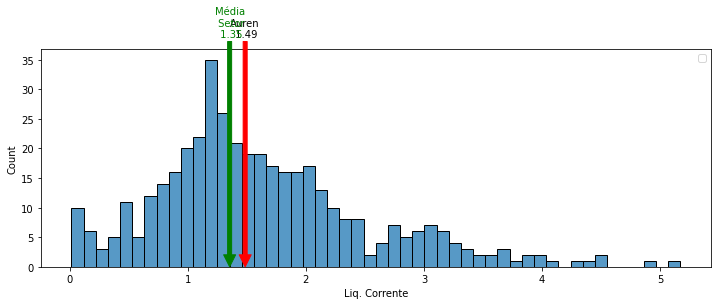

In [23]:
KPI = 'Liq. Corrente'

Q1 = df_indicadores_mean[KPI].quantile(0.25)
Q3 = df_indicadores_mean[KPI].quantile(0.75)

# Calcule o IQR (intervalo interquartil)
IQR = Q3 - Q1

# Defina um fator de escala (por exemplo, 1.5)
scale_factor = 3

# Defina os limites para identificar outliers
lower_limit = Q1 - scale_factor * IQR
upper_limit = Q3 + scale_factor * IQR

# Remova outliers
df_indicadores_filtered = df_indicadores_mean[(df_indicadores_mean[KPI] >= lower_limit) & (df_indicadores_mean[KPI] <= upper_limit)]
df_indicadores_outliers = df_indicadores_mean[(df_indicadores_mean[KPI] <= lower_limit) | (df_indicadores_mean[KPI] >= upper_limit)]
setor_eletrico = df_indicadores_filtered[(df_indicadores_filtered['SETOR_ATIV'] == "Energia Elétrica")]  
mean_sector = setor_eletrico[KPI].mean()

plt.figure(figsize=(12, 4))

sns.histplot(df_indicadores_filtered[KPI],bins=50)

# Encontre as coordenadas para a empresa "Auren"
x_auren = df_indicadores_filtered[df_indicadores_filtered['DENOM_COMERC'] == 'AUREN'][KPI].values[0]
y_max = plt.ylim()[1]  # Obtém o valor máximo no eixo y para posicionar a seta acima do histograma

# Adicione uma seta com o nome da empresa e o valor de Liq. Corrente
plt.annotate('Auren\n {:.2f}'.format(x_auren),
             xy=(x_auren, 0),
             xytext=(x_auren, y_max+2),  # Posição do texto acima da seta
             arrowprops=dict(facecolor='red', edgecolor='red'),
             fontsize=10,
             ha='center')

plt.annotate('Média\n Setor\n {:.2f}'.format(mean_sector),
             xy=(mean_sector, 0),
             xytext=(mean_sector, y_max+2),
             arrowprops=dict(facecolor='green', edgecolor='green'),
             fontsize=10,
             color='green',
             ha='center')
plt.legend()

plt.show()

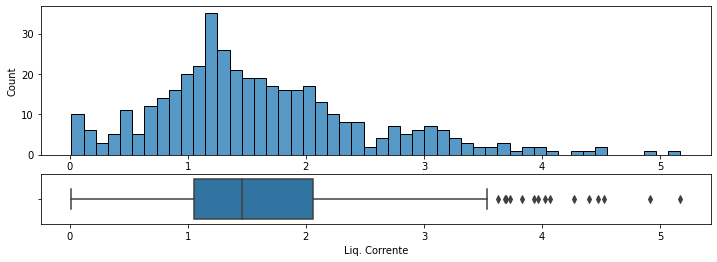

In [24]:
#outliers
filter_extremos = df_indicadores_mean[(df_indicadores_mean[KPI] >= lower_limit) & (df_indicadores_mean[KPI] <= upper_limit)]

# Criando a figura com a grade de subplots
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])  # 2 linhas, 1 coluna

# Plotando o histograma na primeira linha
ax0 = plt.subplot(gs[0])
sns.histplot(filter_extremos[KPI], bins=50, ax=ax0)

# Plotando o boxplot na segunda linha
ax1 = plt.subplot(gs[1])
sns.boxplot(filter_extremos[KPI], whis=1.5, ax=ax1)

plt.show()

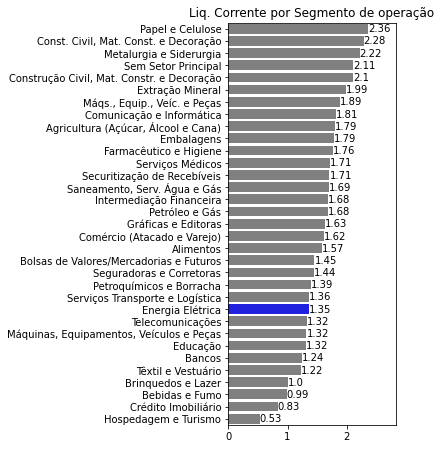

In [25]:
data = df_indicadores_filtered.groupby('SETOR_ATIV').mean().reset_index().sort_values(KPI, ascending=False)
data['Eletric'] = data['SETOR_ATIV'].apply(lambda x: 1 if x == 'Energia Elétrica' else '')


plt.figure(figsize=(3, 7.4))
colors = ['blue' if setor == 'Energia Elétrica' else 'gray' for setor in data['SETOR_ATIV']]
bar_plot = sns.barplot(data=data, y='SETOR_ATIV', x=KPI, palette=colors)

plt.xlim(0, data[KPI].max() * 1.2)
bar_plot.bar_label(bar_plot.containers[0],round(data[KPI],2))

plt.xlabel('')
plt.ylabel('')

# Adiciona título ao gráfico
plt.title(f'{KPI} por Segmento de operação')

# Mostra o gráfico
plt.show()

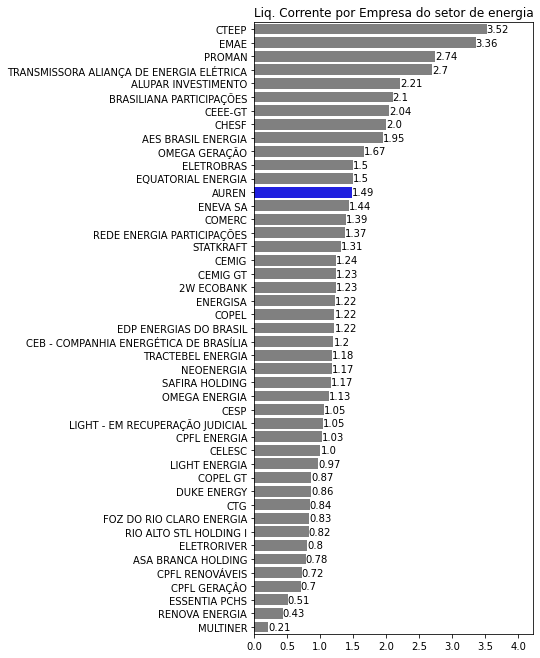

In [26]:
# Remova outliers
data = setor_eletrico.sort_values(KPI, ascending=False)

plt.figure(figsize=(5, len(data)/4))

colors = ['blue' if setor == 'AUREN' else 'gray' for setor in data['DENOM_COMERC']]
bar_plot = sns.barplot(data=data, y='DENOM_COMERC', x=KPI, palette=colors)

plt.xlim(0, data[KPI].max() * 1.2)
bar_plot.bar_label(bar_plot.containers[0],round(data[KPI],2))
plt.xlabel('')
plt.ylabel('')

# Adiciona título ao gráfico
plt.title(f'{KPI} por Empresa do setor de energia')

# Mostra o gráfico
plt.show()

In [27]:
empresa_selecionada = ['CEMIG GT','AUREN','CPFL RENOVÁVEIS','CHESF','CTEEP', 'OMEGA GERAÇÃO','ENEVA SA','STATKRAFT','COPEL GT','CTG']


colunas_EBITDA = ['EBIT',
                  'depreciação e amortização', 'Res. Eq. Patrimonial',
                  'EBITDA',
                  'impairment', 'contencioso', 'dividendos recebidos', 'MtM',
                  'EBITDA ajustado',
                  'Margem EBITDA aj',
                  'Margem Bruta',
                  'Margem Líquida']


dados_empresa = df_final[df_final['DENOM_COMERC'].isin(empresa_selecionada)]
#dados_empresa = dados_empresa[dados_empresa['DT_FIM_EXERC'] == "2022-12-31" ]

dados_empresa_indicadores = df_indicadores[df_indicadores['DENOM_COMERC'].isin(empresa_selecionada)]
#dados_empresa_indicadores = dados_empresa_indicadores[dados_empresa_indicadores['DT_FIM_EXERC'] == "2022-12-31" ]

dados_empresa = dados_empresa.merge(dados_empresa_indicadores,how='left',on='DENOM_COMERC')

EBITDA_ajustado = pd.melt(dados_empresa,id_vars=['DENOM_COMERC'], value_vars= colunas_EBITDA , var_name='Linha', value_name='R$Mil')

#
#EBITDA_ajustado[EBITDA_ajustado['R$Mil'] != 0]
EBITDA_ajustado = EBITDA_ajustado.pivot_table(columns='DENOM_COMERC', index='Linha', values='R$Mil',sort=False).reset_index()

EBITDA_ajustado.iloc[:-3, 1:] = EBITDA_ajustado.iloc[:-3, 1:].applymap(lambda x: f'{x:,.0f}')
EBITDA_ajustado.iloc[-3:, 1:] = EBITDA_ajustado.iloc[-3:, 1:].applymap(lambda x: f'{x:.2%}')
EBITDA_ajustado

DENOM_COMERC,Linha,AUREN,CEMIG GT,CHESF,COPEL GT,CPFL RENOVÁVEIS,CTEEP,CTG,ENEVA SA,OMEGA GERAÇÃO,STATKRAFT
0,EBIT,"984,496","2,131,628","1,276,562","2,387,295","1,055,992","3,200,354","3,599,184","1,130,526","542,706","155,545"
1,depreciação e amortização,"604,756","220,310","112,252","526,298","641,248","18,149","683,906","547,199","315,590","94,686"
2,Res. Eq. Patrimonial,"-65,330","146,173","-53,614","-221,767",0,"-334,563","-89,092","11,950","-20,481","-9,611"
3,EBITDA,"1,523,922","2,498,112","1,335,199","2,691,826","1,697,240","2,883,940","4,193,998","1,689,674","837,815","240,620"
4,impairment,"8,798","3,930","-299,004",0,0,0,0,"-82,499",0,0
5,contencioso,"-202,522",0,"486,531",0,"26,576",0,0,"-6,223",0,"-6,139"
6,dividendos recebidos,"117,521","162,938",0,"40,034","12,430","45,261","63,556",0,"15,510","12,469"
7,MtM,"-90,170",0,0,0,0,0,"-60,422","-81,514","-26,548",0
8,EBITDA ajustado,"1,357,549","2,664,979","1,522,726","2,731,859","1,736,245","2,929,201","4,197,130","1,519,439","826,777","246,951"
9,Margem EBITDA aj,33.36%,34.54%,28.65%,56.54%,69.25%,73.54%,69.84%,38.82%,65.20%,49.93%


In [28]:
colunas_FCO = ['EBITDA ajustado',
               #'IR/CSLL pagos','CGO Caixa','Serviço da dívida',
               #'FCO1',
               #'Outros pagamentos',
               'FCO'
              ]

DF_FCO = pd.melt(dados_empresa,id_vars=['DENOM_COMERC'], value_vars=  colunas_FCO , 
                 var_name='Linha', value_name='R$Mil')

DF_FCO.pivot_table(columns='DENOM_COMERC', index='Linha', values='R$Mil',sort=False).reset_index()

DENOM_COMERC,Linha,AUREN,CEMIG GT,CHESF,COPEL GT,CPFL RENOVÁVEIS,CTEEP,CTG,ENEVA SA,OMEGA GERAÇÃO,STATKRAFT
0,EBITDA ajustado,"1,357,549.00","2,664,979.33","1,522,726.50","2,731,859.33","1,736,244.75","2,929,201.00","4,197,130.50","1,519,439.00","826,776.75","246,950.58"
1,FCO,"714,777.50","1,599,538.17","-444,930.75","1,259,382.50","1,331,435.50","979,927.00","1,747,275.00","1,275,033.50","170,614.17","177,448.17"


In [29]:
divida_liquida = ['Endividamento','disponibilidade', 'Dívida líquida','Alavancagem','I Endiv. Ativo','I Endiv. PL','Liq. Corrente']

alavancagem = pd.melt(dados_empresa,id_vars=['DENOM_COMERC'], value_vars= divida_liquida, var_name='Linha', value_name='R$Mil')
alavancagem = alavancagem.pivot_table(columns=['DENOM_COMERC'], index='Linha', values='R$Mil',sort=False).reset_index()
alavancagem.iloc[:3, 1:] = alavancagem.iloc[:3, 1:].applymap(lambda x: f'{x:,.0f}')

alavancagem

DENOM_COMERC,Linha,AUREN,CEMIG GT,CHESF,COPEL GT,CPFL RENOVÁVEIS,CTEEP,CTG,ENEVA SA,OMEGA GERAÇÃO,STATKRAFT
0,Endividamento,"5,295,446","7,380,016","1,620,146","5,523,397","3,749,579","4,707,614","4,265,820","8,054,671","4,235,548","748,560"
1,disponibilidade,"2,360,888","286,182","158,699","1,216,369","526,886","550,965","1,850,826","1,184,208","681,300","278,398"
2,Dívida líquida,"2,934,558","7,093,834","1,461,447","4,307,028","3,222,693","4,156,649","2,414,994","6,870,463","3,554,248","470,161"
3,Alavancagem,2.16,2.66,0.96,1.58,1.86,1.42,0.58,4.52,4.30,1.90
4,I Endiv. Ativo,0.53,0.70,0.42,0.48,0.58,0.46,0.45,0.69,0.63,0.41
5,I Endiv. PL,1.13,2.07,0.71,0.94,1.37,0.81,0.81,1.59,1.70,0.69
6,Liq. Corrente,1.49,1.23,2.00,0.87,0.72,3.52,0.84,1.44,1.67,1.31


In [30]:
colunas_ROIC = ['EBIT', 'contencioso', 'Res. Eq. Patrimonial',
                'NOP aj',
                'IR/CSLL',
                'NOPAT aj',
                'Aliquota IRCSLL']

dados_empresa['NOP aj'] = (dados_empresa['EBIT'] + dados_empresa[['contencioso','Res. Eq. Patrimonial']].sum(axis=1))
dados_empresa['IR/CSLL'] = -dados_empresa['NOP aj'] * dados_empresa['Aliquota IRCSLL']
dados_empresa['NOPAT aj'] = dados_empresa['NOP aj'] * (1-dados_empresa['Aliquota IRCSLL'])

DF_ROIC = pd.melt(dados_empresa,id_vars=['DENOM_COMERC'], value_vars=  colunas_ROIC , 
                 var_name='Linha', value_name='R$Mil')

DF_ROIC = DF_ROIC.pivot_table(columns='DENOM_COMERC', index='Linha', values='R$Mil',sort=False).reset_index()
DF_ROIC.iloc[:-1, 1:] = DF_ROIC.iloc[:-1, 1:].applymap(lambda x: f'{x:,.0f}')
DF_ROIC.iloc[-1:, 1:] = DF_ROIC.iloc[-1:, 1:].applymap(lambda x: f'{x:.2%}')
DF_ROIC

DENOM_COMERC,Linha,AUREN,CEMIG GT,CHESF,COPEL GT,CPFL RENOVÁVEIS,CTEEP,CTG,ENEVA SA,OMEGA GERAÇÃO,STATKRAFT
0,EBIT,"984,496","2,131,628","1,276,562","2,387,295","1,055,992","3,200,354","3,599,184","1,130,526","542,706","155,545"
1,contencioso,"-202,522",0,"486,531",0,"26,576",0,0,"-6,223",0,"-6,139"
2,Res. Eq. Patrimonial,"-65,330","146,173","-53,614","-221,767",0,"-334,563","-89,092","11,950","-20,481","-9,611"
3,NOP aj,"716,644","2,277,802","1,709,478","2,165,528","1,082,568","2,865,791","3,510,091","1,136,252","522,225","139,796"
4,IR/CSLL,"-164,119","-623,237",0,"-496,655","-18,705","-560,541","-974,054",0,"-196,357","-28,546"
5,NOPAT aj,"552,526","1,654,565","1,709,478","1,668,873","1,063,863","2,305,250","2,536,037","1,136,252","325,868","111,250"
6,Aliquota IRCSLL,22.90%,27.36%,0.00%,22.93%,1.73%,19.56%,27.75%,0.00%,37.60%,20.42%


In [31]:
def abrir_demonstracao_empresa(ano, peca, cod_CVM,ordem='gerencial'):
    # Carregando o DataFrame
    df = pd.read_csv(f"dfp_cia_aberta_{ano}\\{peca}{ano}.CSV", sep=';', encoding='latin-1')
    
    # Filtrando os dados para a empresa desejada
    df_empresa = df[(df['CD_CVM'] == cod_CVM) & (df['VL_CONTA'] != 0)]
    
    # Criando a demonstração de resultado em formato de peça contábil
    demonstracao_resultado = df_empresa.pivot(index=['CD_CONTA','DS_CONTA'], columns='DT_FIM_EXERC', values='VL_CONTA').reset_index()
    
    # Adicionando colunas 'grupo_conta' e 'n_conta'
    demonstracao_resultado['grupo_conta'] = demonstracao_resultado['CD_CONTA'].str.slice(stop=4)
    demonstracao_resultado['n_conta'] = demonstracao_resultado['CD_CONTA'].str.len()

    # Preenchendo os valores da coluna 'CD_CONTA' com noves para garantir 10 dígitos, exceto se já tiver 10 dígitos
    demonstracao_resultado['CD_CONTA'] = demonstracao_resultado['CD_CONTA'].apply(lambda x: str(x) + '.99' * ((10 - len(str(x)))//3) if len(str(x)) < 10 else str(x))
    
    if ordem == 'demonstração':
        demonstracao_resultado.sort_values(by='CD_CONTA', inplace=True)
    else: pass  

    # Retornando a tabela com a formatação condicional aplicada
    return demonstracao_resultado

def formatar_tabela(demonstração_df):
    
    # Função para aplicar a formatação condicional em toda a linha
    def destacar_linha(row):
        if row['n_conta'] <= 4:
            return ['font-weight: bold;background-color: #2C3E50; color: white'] * len(row)
        elif row['n_conta'] == 7:
            return ['font-weight: bold'] * len(row)
        else:
            return [''] * len(row)

    # Aplicando a formatação condicional em toda a linha
    demonstracao_resultado_styled = demonstração_df.style.apply(destacar_linha, axis=1)
    # Seleciona todas as colunas que são números (inteiros ou floats)
    numeric_columns = demonstração_df.select_dtypes(include=['number']).columns

    # Aplica a formatação desejada a todas as colunas numéricas
    demonstracao_resultado_styled.format("{:,.0f}", subset=pd.IndexSlice[:, numeric_columns])
    
    return demonstracao_resultado_styled

In [32]:
df_indicadores_mean[df_indicadores_mean['DENOM_COMERC'] == 'AUREN']['CD_CVM']

416    26620
Name: CD_CVM, dtype: int64

In [33]:
# Exemplo de uso da função
ano = '2022'
peca = 'dfp_cia_aberta_DFC_MI_con_'

tabela_empresa = abrir_demonstracao_empresa(ano, peca, 26620,ordem='demonstração')
#tabela_empresa = tabela_empresa[tabela_empresa['grupo_conta'] == '6.01']
formatar_tabela(tabela_empresa)

DT_FIM_EXERC,CD_CONTA,DS_CONTA,2021-12-31,2022-12-31,grupo_conta,n_conta
2,6.01.01.01,Lucro antes do imposto de renda e da contribuição social,"592,854","3,053,340",6.01,10
3,6.01.01.02,Depreciação e amortização,"558,995","580,092",6.01,10
4,6.01.01.03,Amortização de mais valia,"34,959","35,466",6.01,10
5,6.01.01.04,Baixa de imobilizado e direito de uso dos contratos de arrendamento,"-3,248","6,366",6.01,10
6,6.01.01.05,Repactuação do risco hidrológico,"-781,974",nan,6.01,10
7,6.01.01.06,Provisão de obrigações socioambientais,"7,607","1,593",6.01,10
8,6.01.01.07,Equivalência patrimonial,nan,"-130,659",6.01,10
9,6.01.01.08,Juros e variações monetárias,"421,627","156,366",6.01,10
10,6.01.01.09,Apropriação de custos de captação,"13,739","13,108",6.01,10
11,6.01.01.10,Baixa de depósitos judiciais,"75,185","4,983",6.01,10


In [34]:
df_indicadores_mean.to_excel('df_indicadores_3.xlsx')